# Adult Income Classification Experiments

## Import Libraries Needed for Experiment

In [86]:
# Import Python Libraries
import sys
import warnings
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder
from imblearn.over_sampling import SMOTENC

# Append Path to Prevent Module Not Found Errors in Notebooks
sys.path.append('C:/Users/ameen/OneDrive/Documents/github/Classic-ML-Models/src')
warnings.filterwarnings('ignore')

# Import Custom Modules/Classes/Functions
from utils.helpers.etl_helpers import extract_csv, train_test_val_split
from utils.helpers.visual_helpers import cat_distribution, num_distribution
from utils.aws.s3 import S3Buckets
s3_conn = S3Buckets.credentials()

## Import Dataset and View Dataset Information

In [29]:
csv_file = s3_conn.read_file("jibbs-raw-datasets", "uncleaned_AdultData.csv")
df = extract_csv(csv_file)

INFO: Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO: File 'uncleaned_AdultData.csv' read successfully from bucket 'jibbs-raw-datasets'.


In [30]:
# Make a copy of the dataframe and View the Data Info
adult = df.copy()
adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  salary          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


## Identify Datatypes in Dataset

In [31]:
# Identify the target column
target_col = 'salary'

# Identifying numerical columns
numerical_cols = adult.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Identifying categorical columns
categorical_cols = adult.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in [target_col]]

# Display the target, numerical and categorical columns
print("Target Column:", target_col)
print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

Target Column: salary
Numerical Columns: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical Columns: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


## Check Data Distributions

In [32]:
for col in categorical_cols:
    print(f"Number of Unique values in {col}: {adult[col].nunique()}")

Number of Unique values in workclass: 9
Number of Unique values in education: 16
Number of Unique values in marital-status: 7
Number of Unique values in occupation: 15
Number of Unique values in relationship: 6
Number of Unique values in race: 5
Number of Unique values in sex: 2
Number of Unique values in native-country: 42


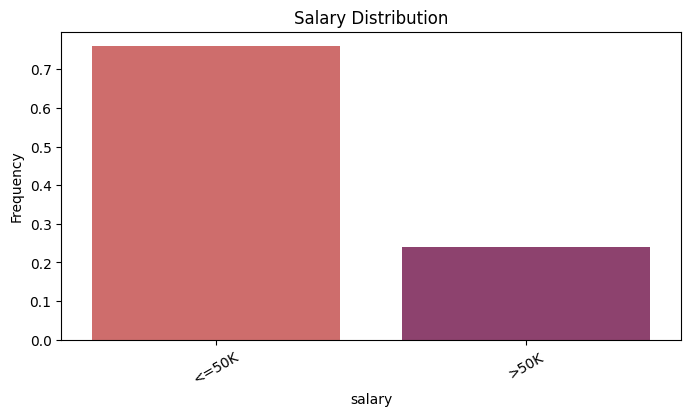

In [33]:
# Visualize the Distribution of the Target
cat_distribution(adult, "salary")

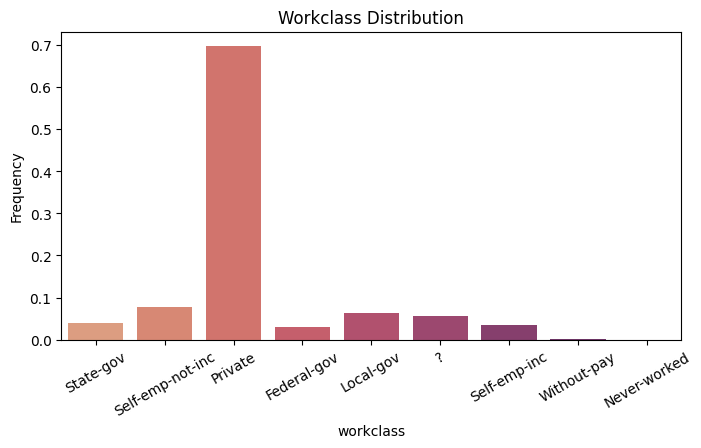

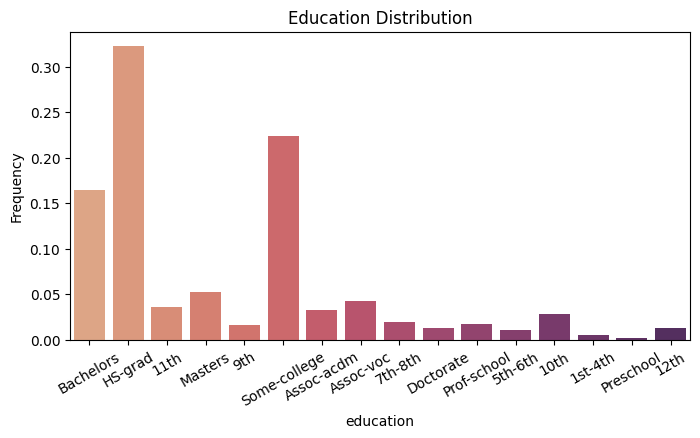

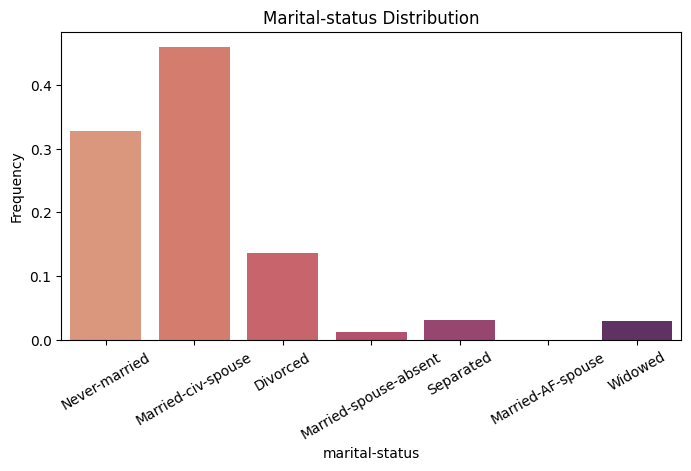

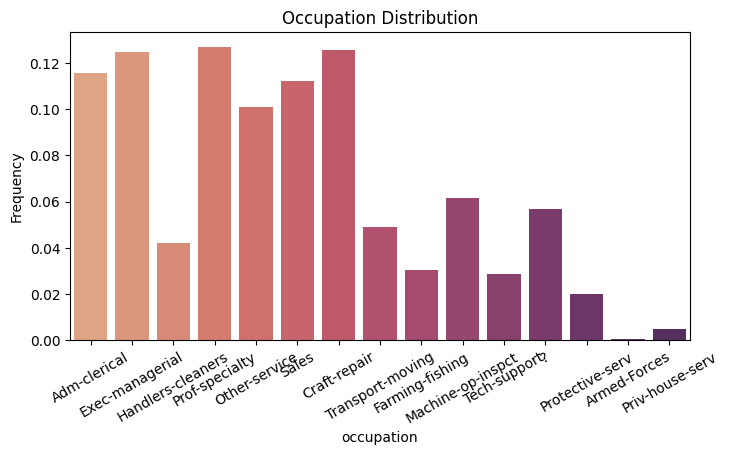

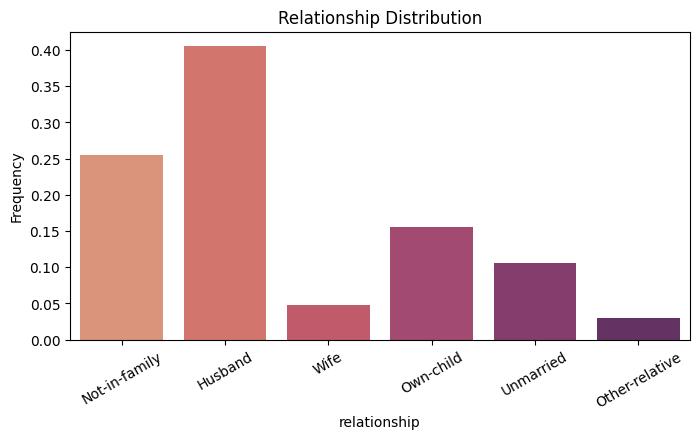

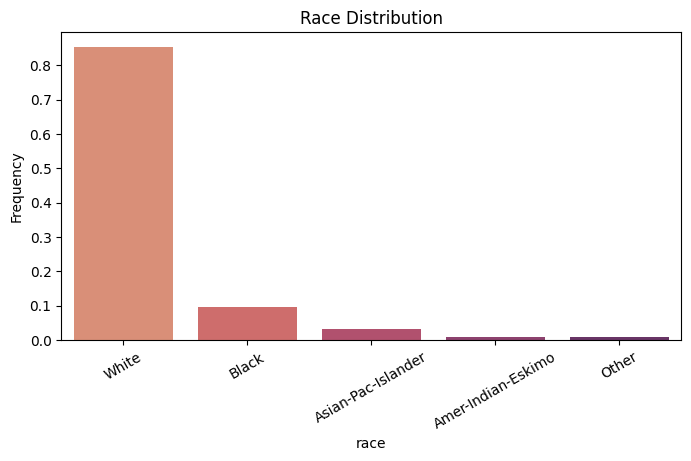

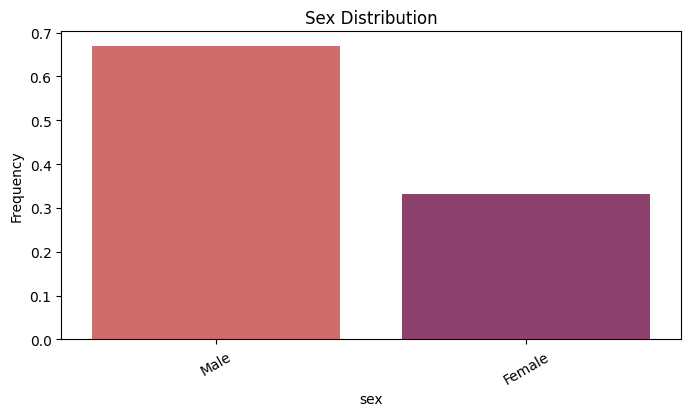

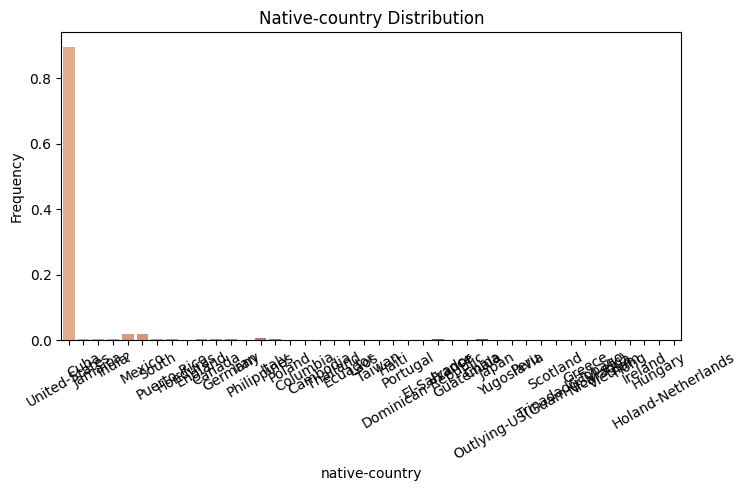

In [34]:
for col in categorical_cols:
    cat_distribution(adult, col)

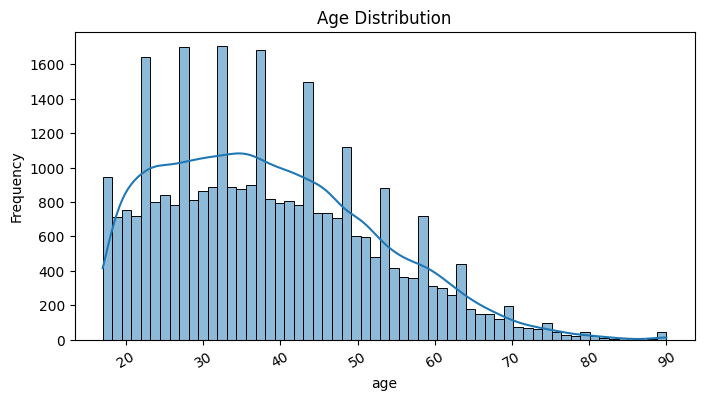

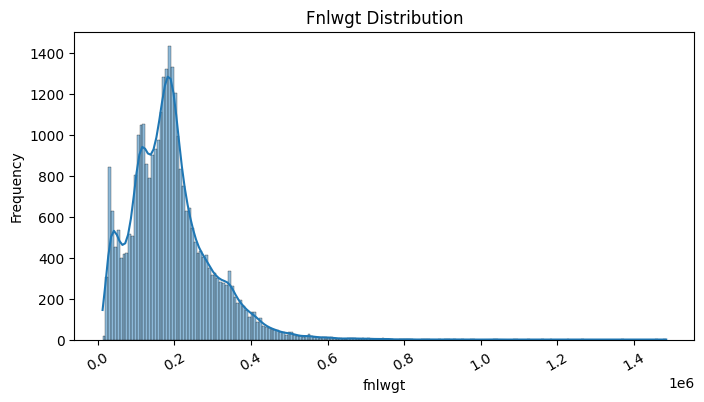

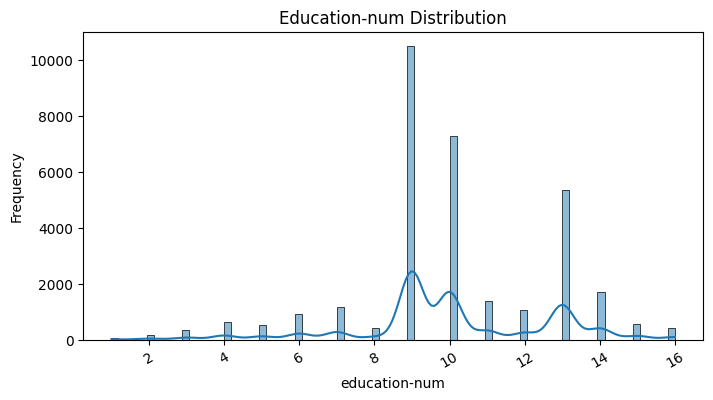

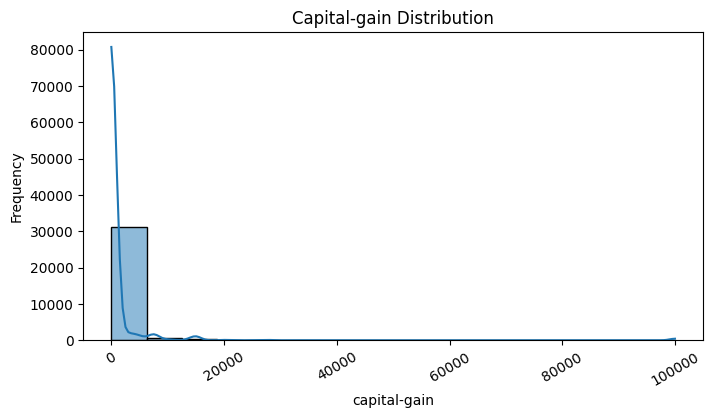

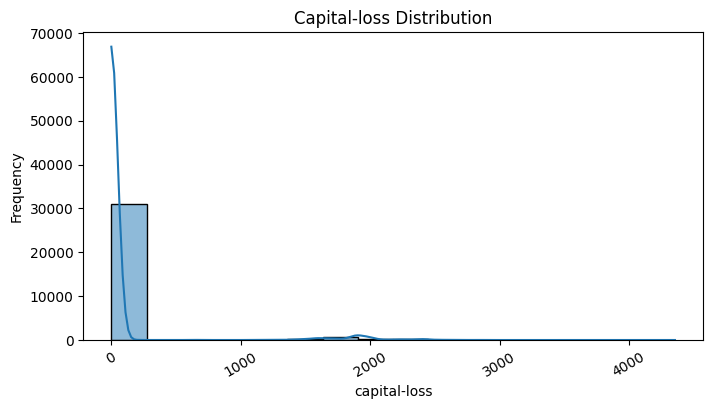

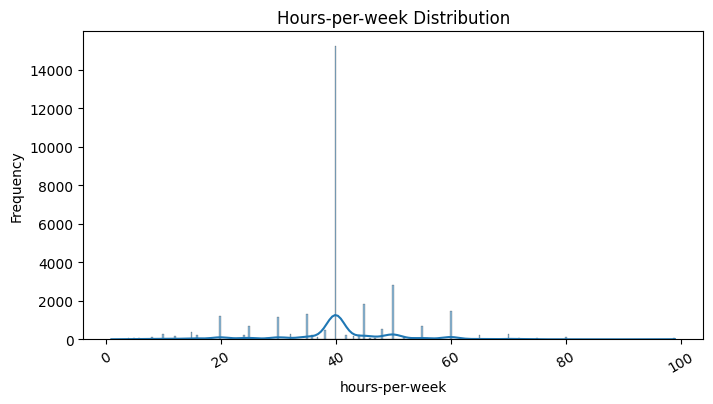

In [35]:
for col in numerical_cols:
    num_distribution(adult, col)

## Data Preprocessing and Feature Engineering

- **Scale Numeric Variables** : Numerical variables will be scaled to ensure that the model is not biased towards
variables with higher magnitudes in the features.

- **Label Encoding** : Categorical variables are encoded with numeric data. I choose target encoding here to deal with the issue of high cardinality in several categorical features. 

- **Missing Values** : Missing numeric variables will br imputed using the median as it is less sensitive to outliers in the data. For categorical varables, missing variables are imputed using the mode of the feature. This imputation was not done because the data came with no missing values. 

- **Resample Target** : The target will be resampled to allow representation in the dataset. The distribution of the target classes is currently around 3:1 and could introduce some bias to the model since it is trained on more of one target than another (I call this the familiarity bias).

In [36]:
# Scaling the numerical columns
scaler = MinMaxScaler()
adult[numerical_cols] = scaler.fit_transform(adult[numerical_cols])

In [37]:
# Label Encode the Target
le = LabelEncoder()
adult[target_col] = le.fit_transform(adult[target_col])


In [38]:
# Target Encoding the Categorical Columns
encoder = TargetEncoder()
adult[categorical_cols] = encoder.fit_transform(adult[categorical_cols], adult[target_col])

## Dataset Splits (Test and Train Datasets)

In [ ]:
# Split the Data into Train, Test and Validation Sets
X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(adult, target_col)

## Train Models, Evaluate Metrics on Validation and Test Datasets

In [47]:
# First, we will use the SMOTENC technique to oversample the minority class
print('Original train data distribution:')
print('Class 0:', np.bincount(y_train)[0], 'Class 1:', np.bincount(y_train)[1])

# Initialize SMOTENC specifying which features are categorical
smote_nc = SMOTENC(categorical_features=categorical_cols, random_state=2024)

# Perform the resampling
X_resampled, y_resampled = smote_nc.fit_resample(X_train, y_train)

# Print the resampled data size and class distribution
print('Resampled train data distribution:')
print('Class 0:', np.bincount(y_resampled)[0], 'Class 1:', np.bincount(y_resampled)[1])

Original train data distribution:
Class 0: 17260 Class 1: 5532
Resampled train data distribution:
Class 0: 17260 Class 1: 17260


- **Model** : The data is first trained on the model with no hyperparameters tuned.

- **Model with Hyperparameter Tuning** : The model is also trained with its hyperparameters tuned to get the best performing set of hyperparameters based on the specified metric.

- **Metrics** : Several metrics such as accuracy, F1 Score, Precision, Recall and ROC-AUC Scores are added and the metric selected is based on the use case of the model.

### Logistic Regression - Base Model

In [89]:
base_model = LogisticRegression(random_state=2024)
base_model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=2024)

In [90]:
# Check the Model Metrics
print("Model Metrics on Validation Set")
y_val_pred = base_model.predict(X_val)
print("Model Accuracy:", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall:", recall_score(y_val, y_val_pred))
print("F1 Score:", f1_score(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("\n")
print ("Model Metrics on Test Set")
y_test_pred = base_model.predict(X_test)
print("Model Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("F1 Score:", f1_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

Model Metrics on Validation Set
Model Accuracy: 0.8143314139475368
Precision: 0.572744014732965
Recall: 0.8423618634886241
F1 Score: 0.6818680114010085
ROC-AUC: 0.8240122267686042
Confusion Matrix:
 [[4809 1160]
 [ 291 1555]]


Model Metrics on Test Set
Model Accuracy: 0.8027433718906746
Precision: 0.5556526806526807
Recall: 0.8258986574274578
F1 Score: 0.6643441909075074
ROC-AUC: 0.8107375324670802
Confusion Matrix:
 [[5935 1525]
 [ 402 1907]]


In [95]:
# Hyperparameter Tuning using GridSearchCV
# Define the parameter grid
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300, 500]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=LogisticRegression(random_state=2024), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_resampled, y_resampled)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Initialize the model with the best parameters
tuned_base_model = LogisticRegression(**grid_search.best_params_, random_state=2024)
tuned_base_model.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Best Parameters: {'C': 1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.8262746234067209


LogisticRegression(C=1, penalty='l1', random_state=2024, solver='liblinear')

In [96]:
# Check the Model Metrics
print("Model Metrics on Validation Set")
y_val_pred = tuned_base_model.predict(X_val)
print("Model Accuracy:", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall:", recall_score(y_val, y_val_pred))
print("F1 Score:", f1_score(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("\n")
print ("Model Metrics on Test Set")
y_test_pred = tuned_base_model.predict(X_test)
print("Model Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("F1 Score:", f1_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


Model Metrics on Validation Set
Model Accuracy: 0.817658349328215
Precision: 0.5789276340457443
Recall: 0.8364030335861322
F1 Score: 0.6842455129625526
ROC-AUC: 0.8241321584415835
Confusion Matrix:
 [[4846 1123]
 [ 302 1544]]


Model Metrics on Test Set
Model Accuracy: 0.8067355921793428
Precision: 0.5620394930739758
Recall: 0.8258986574274578
F1 Score: 0.6688881094352859
ROC-AUC: 0.8133514734858469
Confusion Matrix:
 [[5974 1486]
 [ 402 1907]]


### Decision Tree Classifier - Alternative Model 1

In [97]:
alt_model_1 = DecisionTreeClassifier(random_state=2024)
alt_model_1.fit(X_resampled, y_resampled)

DecisionTreeClassifier(random_state=2024)

In [98]:
# Check the Model Metrics
print("Model Metrics on Validation Set")
y_val_pred = alt_model_1.predict(X_val)
print("Model Accuracy:", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall:", recall_score(y_val, y_val_pred))
print("F1 Score:", f1_score(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("\n")
print ("Model Metrics on Test Set")
y_test_pred = alt_model_1.predict(X_test)
print("Model Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("F1 Score:", f1_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

Model Metrics on Validation Set
Model Accuracy: 0.9753039027511197
Precision: 0.9356879283078545
Recall: 0.9615384615384616
F1 Score: 0.948437082554101
ROC-AUC: 0.9705497635217857
Confusion Matrix:
 [[5847  122]
 [  71 1775]]


Model Metrics on Test Set
Model Accuracy: 0.8011055379260927
Precision: 0.5670821114369502
Recall: 0.6699870073624946
F1 Score: 0.6142545165773278
ROC-AUC: 0.7558380077026949
Confusion Matrix:
 [[6279 1181]
 [ 762 1547]]


In [99]:
# Hyperparameter Tuning using GridSearchCV
# Define the parameter grid 
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=2024), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_resampled, y_resampled)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Initialize the model with the best parameters
tuned_alt_model_1 = DecisionTreeClassifier(**grid_search.best_params_, random_state=2024)
tuned_alt_model_1.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score: 0.8491599073001158


DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features='sqrt',
                       random_state=2024)

In [100]:
# Check the Model Metrics
print("Model Metrics on Validation Set")
y_val_pred = tuned_alt_model_1.predict(X_val)
print("Model Accuracy:", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall:", recall_score(y_val, y_val_pred))
print("F1 Score:", f1_score(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("\n")
print ("Model Metrics on Test Set")
y_test_pred = tuned_alt_model_1.predict(X_test)
print("Model Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("F1 Score:", f1_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

Model Metrics on Validation Set
Model Accuracy: 0.8923864363403711
Precision: 0.7098121085594989
Recall: 0.9209100758396533
F1 Score: 0.801697712803584
ROC-AUC: 0.902237581059381
Confusion Matrix:
 [[5274  695]
 [ 146 1700]]


Model Metrics on Test Set
Model Accuracy: 0.8011055379260927
Precision: 0.5569738480697385
Recall: 0.7747942832394976
F1 Score: 0.6480710016301394
ROC-AUC: 0.7920218064991054
Confusion Matrix:
 [[6037 1423]
 [ 520 1789]]


### Random Forest Classifier - Alternative Model 2

In [101]:
alt_model_2 = RandomForestClassifier(random_state=2024)
alt_model_2.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=2024)

In [103]:
# Check the Model Metrics
print("Model Metrics on Validation Set")
y_val_pred = alt_model_2.predict(X_val)
print("Model Accuracy:", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall:", recall_score(y_val, y_val_pred))
print("F1 Score:", f1_score(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("\n")
print ("Model Metrics on Test Set")
y_test_pred = alt_model_2.predict(X_test)
print("Model Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("F1 Score:", f1_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

Model Metrics on Validation Set
Model Accuracy: 0.9805502239283429
Precision: 0.9500531349628055
Recall: 0.9685807150595883
F1 Score: 0.9592274678111588
ROC-AUC: 0.9764163417817626
Confusion Matrix:
 [[5875   94]
 [  58 1788]]


Model Metrics on Test Set
Model Accuracy: 0.8419490224178524
Precision: 0.6484284051222352
Recall: 0.7236899090515375
F1 Score: 0.6839950880065493
ROC-AUC: 0.8011210939359564
Confusion Matrix:
 [[6554  906]
 [ 638 1671]]


In [ ]:
# Hyperparameter Tuning using GridSearchCV
# Define the parameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300, 400, 500],
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [10, 20, 30, 40, 50],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt', 'log2']
# }

# # Initialize the GridSearchCV object
# tuned_alt_model_2 = GridSearchCV(estimator=RandomForestClassifier(random_state=2024), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# # Fit the grid search to the data
# tuned_alt_model_2.fit(X_resampled, y_resampled)

# # Print the best parameters and best score
# print("Best Parameters:", tuned_alt_model_2.best_params_)
# print("Best Score:", tuned_alt_model_2.best_score_)

# # Initialize the model with the best parameters
# tuned_alt_model_2 = RandomForestClassifier(**tuned_alt_model_2.best_params_, random_state=2024)
best_params = {'criterion': 'entropy', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
tuned_alt_model_2 = RandomForestClassifier(**best_params, random_state=2024)
tuned_alt_model_2.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 1350 candidates, totalling 6750 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best Score: 0.8925550405561993


RandomForestClassifier(criterion='entropy', max_depth=40, n_estimators=500,
                       random_state=2024)

In [105]:
# Check the Model Metrics
print("Model Metrics on Validation Set")
y_val_pred = tuned_alt_model_2.predict(X_val)
print("Model Accuracy:", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall:", recall_score(y_val, y_val_pred))
print("F1 Score:", f1_score(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("\n")
print ("Model Metrics on Test Set")
y_test_pred = tuned_alt_model_2.predict(X_test)
print("Model Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("F1 Score:", f1_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

Model Metrics on Validation Set
Model Accuracy: 0.980294305822137
Precision: 0.95
Recall: 0.9674972914409534
F1 Score: 0.9586688137412775
ROC-AUC: 0.9758746299724452
Confusion Matrix:
 [[5875   94]
 [  60 1786]]


Model Metrics on Test Set
Model Accuracy: 0.8435868563824342
Precision: 0.6505977632086386
Recall: 0.7306193157210914
F1 Score: 0.6882904936760506
ROC-AUC: 0.8045857972707333
Confusion Matrix:
 [[6554  906]
 [ 622 1687]]
